# A Simple Example

## Introduction

This notebook provides a straightforward example comparing a Neural Controlled Differential Equation (NCDE) and a Log Neural Controlled Differential Equation (Log-NCDE) on a synthetic three-dimensional time series classification task.

## Data Description

The synthetic dataset contains 5000 time series, each with 200 observations and 3 channels. The first channel represents time, while the second and third channels contain sinusoidal waves. These sinusoidal waves begin at a random point during the time series and last for 20 observations. The dataset contains two classes, differentiated by the frequencies of the sinusoidal waves in each channel.

| Class | Channel 2 Frequency | Channel 3 Frequency |
|:-----:|:-------------------:|:-------------------:|
|   1   |         1           |        1.1          |
|   2   |        1.1          |         1           |

In this table:
- **Class** denotes the classification of the time series.
- **Channel 2 Frequency** and **Channel 3 Frequency** indicate the frequency of the sinusoidal waves in the respective channels.

## Models

Both the NCDE and Log-NCDE employ a Multi-Layer Perceptron (MLP) vector field with SiLU activation functions in the hidden layers and a tanh activation function after the final layer. The NCDE uses a Hermite cubic spline with backward differences for interpolation. Both models utilise Heun's method as their differential equation solver.

## Training and Evaluation

The data is split into a train and test set. A NCDE, a depth-1 Log-NCDE, and a depth-2 Log-NCDE are trained on the training set using the Adam optimiser with a learning rate of 3e-4. The test accuracies fo each model are plotted against number of training steps. Generating the dataset and training the models should take <10 minutes to run on a laptop.

## Considerations

The following code is designed for simplicity and is not the most efficient implementation of NCDEs or Log-NCDEs. Specifically, calculating the coefficients for NCDEs and the log-signatures for Log-NCDEs should ideally be performed once for the entire dataset as a preprocessing step, rather than during each forward pass.

In [1]:
# Import necessary libraries
import diffrax  # Differential equation solvers
import equinox as eqx  # Neural network library
import jax  # Main JAX library
import jax.numpy as jnp  # JAX version of NumPy
import jax.random as jr  # JAX random number generation
import matplotlib.pyplot as plt  # Matplotlib for plotting
import optax  # Optimiser library for JAX

# Import specific functions from signax for handling log-signature calculation
from signax.signature import signature  # For computing signatures of paths
from signax.signature_flattened import flatten  # For flattening signatures
from signax.tensor_ops import log  # For converting to log-signatures

# Import a HallSet class, which is used to identify which lie brackets are necessary when using a depth-2 Log-ODE method
from data_dir.hall_set import HallSet

In [2]:
# Define the NeuralCDE class
class NeuralCDE(eqx.Module):
    vf: eqx.nn.MLP  # Vector field parameterised as an MLP
    data_dim: int  # Dimension of the input data
    hidden_dim: int  # Dimension of the hidden state
    ode_solver_stepsize: int  # Step size for the ODE solver
    linear1: eqx.nn.Linear  # Linear layer to initialise hidden state
    linear2: eqx.nn.Linear  # Linear layer for output prediction

    def __init__(
        self,
        hidden_dim,
        data_dim,
        label_dim,
        vf_hidden_dim,
        vf_num_hidden,
        ode_solver_stepsize,
        *,
        key,
    ):
        # Split the random key into three parts for initialising layers
        vf_key, l1key, l2key = jr.split(key, 3)
        # Initialise the MLP vector field
        self.vf = eqx.nn.MLP(
            hidden_dim,
            hidden_dim * data_dim,
            vf_hidden_dim,
            vf_num_hidden,
            activation=jax.nn.silu,
            final_activation=jax.nn.tanh,
            key=vf_key,
        )
        # Initialise the linear layers
        self.linear1 = eqx.nn.Linear(data_dim, hidden_dim, key=l1key)
        self.linear2 = eqx.nn.Linear(hidden_dim, label_dim, key=l2key)
        # Set other attributes
        self.hidden_dim = hidden_dim
        self.data_dim = data_dim
        self.ode_solver_stepsize = ode_solver_stepsize

    # Method to get the ODE term
    def get_ode(self, ts, X):
        # Compute backward Hermite coefficients for interpolation
        coeffs = diffrax.backward_hermite_coefficients(ts, X)
        # Create a cubic interpolation control term
        control = diffrax.CubicInterpolation(ts, coeffs)
        # Reshape output from vector field to be matrix-valued
        func = lambda t, y, args: jnp.reshape(
            self.vf(y), (self.hidden_dim, self.data_dim)
        )
        # Return the control term converted to an ODE
        return diffrax.ControlTerm(func, control).to_ode()

    # Forward pass method
    def __call__(self, X):
        ts = X[:, 0]  # Assume time is the first channel
        # Get the ODE term
        ode_term = self.get_ode(ts, X)

        # Initialise the hidden state
        h0 = self.linear1(X[0, :])
        saveat = diffrax.SaveAt(t1=True)  # Save only the final time point
        # Solve the differential equation
        solution = diffrax.diffeqsolve(
            terms=ode_term,
            solver=diffrax.Heun(),  # Use Heun's method for solving
            t0=ts[0],
            t1=ts[-1],
            dt0=self.ode_solver_stepsize,
            y0=h0,
            saveat=saveat,
            stepsize_controller=diffrax.ConstantStepSize(),
        )

        # Apply the second linear layer and softmax to get the prediction
        return jax.nn.softmax(self.linear2(solution.ys[-1]))

In [3]:
# Define the LogNeuralCDE class, which is identical to NeuralCDE, except for the get_ode method
class LogNeuralCDE(NeuralCDE):
    stepsize: int  # The interval size for the Log-ODE method
    depth: int  # The log-signature truncation depth for the Log-ODE method
    hall_set: HallSet  # Hall set for Lie bracket computations

    def __init__(
        self,
        hidden_dim,
        data_dim,
        label_dim,
        vf_hidden_dim,
        vf_num_hidden,
        ode_solver_stepsize,
        stepsize,
        depth,
        *,
        key,
    ):
        # Initialise the parent class NeuralCDE
        super().__init__(
            hidden_dim,
            data_dim,
            label_dim,
            vf_hidden_dim,
            vf_num_hidden,
            ode_solver_stepsize,
            key=key,
        )
        self.stepsize = stepsize
        # Ensure the depth is either 1 or 2
        if depth not in [1, 2]:
            raise ValueError(
                "The Log-ODE method is only implemented for truncation depths one and two"
            )
        self.depth = depth
        self.hall_set = HallSet(data_dim, depth)

    # Method to calculate log-signatures
    def calc_logsigs(self, X):
        # Reshape data
        X = X.reshape(-1, self.stepsize, X.shape[-1])

        # Prepend zero to the first interval and the last element of the previous interval to every other interval
        prepend = jnp.concatenate((jnp.zeros((1, X.shape[-1])), X[:-1, -1, :]))[
            :, None, :
        ]
        X = jnp.concatenate((prepend, X), axis=1)

        # Define log-signature function
        def logsig(x):
            logsig = flatten(log(signature(x, self.depth)))
            if self.depth == 1:
                return jnp.concatenate((jnp.array([0]), logsig))
            else:
                tensor_to_lie_map = self.hall_set.t2l_matrix(self.depth)
                return tensor_to_lie_map[:, 1:] @ logsig

        # Calculate log-signatures over each interval
        logsigs = jax.vmap(logsig)(X)

        return logsigs

    # ODE for depth one Log-ODE method
    def depth_one_ode(self, y, logsig, interval_length):
        # Reshape output from vector field to be matrix-valued
        vf_out = jnp.reshape(self.vf(y), (self.hidden_dim, self.data_dim))
        # Exclude first term of log-signature, which is always zero
        return jnp.dot(vf_out, logsig[1:]) / interval_length

    # ODE for depth two Log-ODE method
    def depth_two_ode(self, y, logsig, interval_length):
        # Reshape output from vector field to be matrix-valued
        vf_out = jnp.reshape(self.vf(y), (self.hidden_dim, self.data_dim))

        # Calculate Jacobian-vector products used to compute the Lie brackets
        jvps = jnp.reshape(
            jax.vmap(lambda x: jax.jvp(self.vf, (y,), (x,))[1])(vf_out.T),
            (self.data_dim, self.data_dim, self.hidden_dim),
        )

        # Compute Lie brackets
        def liebracket(jvps, pair):
            return jvps[pair[0] - 1, pair[1] - 1] - jvps[pair[1] - 1, pair[0] - 1]

        pairs = jnp.asarray(self.hall_set.data[self.data_dim + 1 :])
        lieout = jax.vmap(liebracket, in_axes=(None, 0))(jvps, pairs)

        # Combine Lie brackets with the log-signature
        vf_depth1 = jnp.dot(vf_out, logsig[1 : self.data_dim + 1])
        vf_depth2 = jnp.dot(lieout.T, logsig[self.data_dim + 1 :])

        return (vf_depth1 + vf_depth2) / interval_length

    # Define get_ode using the Log-ODE method
    def get_ode(self, ts, X):
        # Calculate the log-signatures
        logsigs = self.calc_logsigs(X)
        # Calculate intervals, assuming 0<=t<=1
        intervals = (
            jnp.arange(0, X.shape[0] + self.stepsize, self.stepsize) / X.shape[0]
        )

        # Define ODE function
        def func(t, y, args):
            idx = jnp.searchsorted(intervals, t)
            logsig_t = logsigs[idx - 1]
            interval_length = intervals[idx] - intervals[idx - 1]
            if self.depth == 1:
                return self.depth_one_ode(y, logsig_t, interval_length)
            if self.depth == 2:
                return self.depth_two_ode(y, logsig_t, interval_length)

        return diffrax.ODETerm(func)

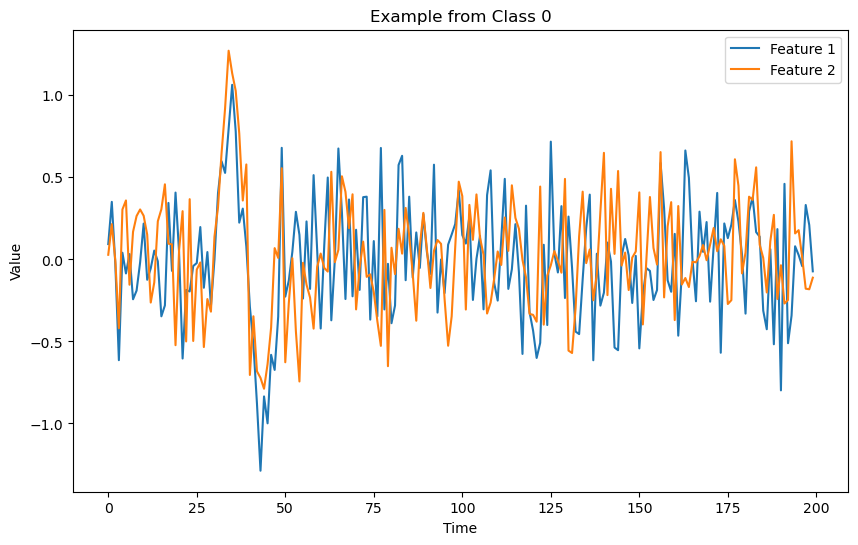

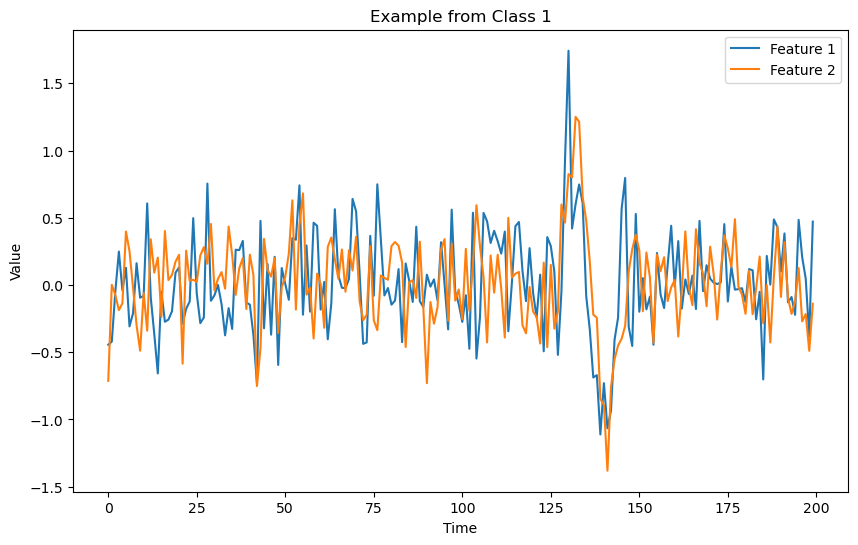

In [4]:
# Generate synthetic multivariate time series data using JAX
def generate_multivariate_sine_wave(frequencies, length, noise_level, key):
    t = jnp.linspace(0, 1, length)  # Generate time points
    num_features = len(frequencies)  # Number of features in the data
    data = jnp.zeros((length, num_features))  # Initialise data array
    for i, freq in enumerate(frequencies):
        noisekey, key = jr.split(key)  # Split key for noise generation
        noise = jr.normal(noisekey, shape=(length,)) * noise_level  # Generate noise
        data = data.at[:, i].set(
            jnp.sin(2 * jnp.pi * freq * t) + noise
        )  # Add sine wave with noise
    return data


# Parameters for synthetic data generation
num_samples = 5000  # Total number of time series
signal_length = 20  # Length of each signal
total_length = 200  # Total length of each time series
num_features = 2  # Number of features (dimensionality)
noise_level = 0.3  # Noise level

# Generate data for two classes
key = jax.random.PRNGKey(0)  # Initialise random key
key, datakey = jr.split(key)  # Split key for data generation
keys = jax.random.split(datakey, num=num_samples)  # Generate multiple keys

# Generate signals for each class
vmap_generate_multivariate_sine_wave = jax.vmap(
    generate_multivariate_sine_wave, in_axes=(None, None, None, 0)
)
signal_class_0 = vmap_generate_multivariate_sine_wave(
    [1, 1.1], signal_length, noise_level, keys[: num_samples // 2]
)
signal_class_1 = vmap_generate_multivariate_sine_wave(
    [1.1, 1], signal_length, noise_level, keys[num_samples // 2 :]
)

# Initialise data with noise
noisekey, key = jr.split(key, 2)
data_class_0 = (
    jr.normal(noisekey, shape=(num_samples // 2, total_length, num_features))
    * noise_level
)
# Add the signal at a random time point
for i in range(num_samples // 2):
    offsetkey, key = jr.split(key)
    offset = jax.random.randint(offsetkey, (), 0, total_length - signal_length)
    data_class_0 = data_class_0.at[i, offset : offset + signal_length].set(
        signal_class_0[i]
    )

noisekey, key = jr.split(key, 2)
data_class_1 = (
    jr.normal(noisekey, shape=(num_samples // 2, total_length, num_features))
    * noise_level
)
for i in range(num_samples // 2):
    offsetkey, key = jr.split(key)
    offset = jax.random.randint(offsetkey, (), 0, total_length - signal_length)
    data_class_1 = data_class_1.at[i, offset : offset + signal_length].set(
        signal_class_1[i]
    )

# Add time as the first channel
t = jnp.repeat(jnp.linspace(0, 1, total_length)[None, :], num_samples // 2, axis=0)[
    ..., None
]
data_class_0 = jnp.concatenate([t, data_class_0], axis=2)
data_class_1 = jnp.concatenate([t, data_class_1], axis=2)

# Labels for the two classes
labels_class_0 = jnp.zeros((num_samples // 2, 2)).at[:, 0].set(1)  # Class 0 labels
labels_class_1 = jnp.zeros((num_samples // 2, 2)).at[:, 1].set(1)  # Class 1 labels

# Combine the data and labels
X = jnp.concatenate((data_class_0, data_class_1), axis=0)
y = jnp.concatenate((labels_class_0, labels_class_1), axis=0)

# Shuffle the data
key, subkey = jr.split(key)
indices = jr.permutation(subkey, num_samples)  # Generate random permutation of indices
X_shuffled = X[indices]
y_shuffled = y[indices]

# Split the data into training and test sets
split_index = int(num_samples * 0.8)
X_train = X_shuffled[:split_index]
y_train = y_shuffled[:split_index]
X_test = X_shuffled[split_index:]
y_test = y_shuffled[split_index:]


# Visualise the data
def plot_multivariate_time_series(data, title):
    plt.figure(figsize=(10, 6))
    for feature in range(1, data.shape[1]):  # Plot each feature separately
        plt.plot(data[:, feature], label=f"Feature {feature}")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


# Plot examples from each class
plot_multivariate_time_series(data_class_0[0], "Example from Class 0")
plot_multivariate_time_series(data_class_1[0], "Example from Class 1")

In [5]:
# Define the Dataloader class
class Dataloader:
    data: jnp.ndarray  # Data array
    labels: jnp.ndarray  # Labels array
    size: int  # Size of the dataset

    def __init__(self, data, labels):
        self.data = data  # Initialise data
        self.labels = labels  # Initialise labels
        self.size = len(data)  # Set the size of the dataset

    # Method to create an infinite loop of data batches
    def loop(self, batch_size, *, key=None):
        # If the batch size is equal to the dataset size, yield the whole dataset
        if batch_size == self.size:
            yield self.data, self.labels

        indices = jnp.arange(self.size)  # Generate an array of indices
        while True:
            subkey, key = jr.split(key)  # Split the key for random permutation
            perm = jr.permutation(subkey, indices)  # Permute the indices
            start = 0
            end = batch_size
            # Yield batches of data and labels
            while end < self.size:
                batch_perm = perm[start:end]  # Select a batch of permuted indices
                yield self.data[batch_perm], self.labels[batch_perm]
                start = end  # Update start index
                end = start + batch_size  # Update end index


# Initialise dataloaders for training and testing data
train_dataloader = Dataloader(X_train, y_train)
test_dataloader = Dataloader(X_test, y_test)

In [6]:
# Define the classification loss function with gradient calculation
@eqx.filter_value_and_grad
def classification_loss(model, X, y):
    # Predict the output using the model
    pred_y = jax.vmap(model)(X)
    # Calculate the cross-entropy loss
    return jnp.mean(-jnp.sum(y * jnp.log(pred_y + 1e-8), axis=1))


# Define the training step function with JIT compilation
@eqx.filter_jit
def train_step(model, X, y, opt, opt_state):
    # Calculate loss and gradients
    loss, grads = classification_loss(model, X, y)
    # Update optimiser state and get parameter updates
    updates, opt_state = opt.update(grads, opt_state)
    # Apply parameter updates to the model
    model = eqx.apply_updates(model, updates)
    # Return the updated model and optimiser state
    return model, opt_state

In [7]:
# Define the training function for the model
def train_model(
    model,
    num_steps=2000,  # Number of training steps
    print_steps=100,  # Interval for printing accuracy
    batch_size=32,  # Batch size for training
    opt=optax.adam(
        learning_rate=3e-4
    ),  # Optimiser with Adam and specified learning rate
    *,
    key,
):
    # Initialise the optimiser state
    opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))
    # Split the random key for training loop
    trainloopkey, key = jr.split(key)
    test_accs = []  # List to store test accuracies
    steps = []  # List to store step numbers

    # Training loop
    for step, data in zip(
        range(num_steps), train_dataloader.loop(batch_size, key=trainloopkey)
    ):
        X, y = data  # Get a batch of training data
        # Perform a training step
        model, opt_state = train_step(model, X, y, opt, opt_state)

        # Print and evaluate accuracy at specified intervals
        if step == 0 or (step + 1) % print_steps == 0:
            # Calculate training accuracy on the entire training dataset
            for batch, data in zip(
                range(1), train_dataloader.loop(train_dataloader.size)
            ):
                X, y = data
                output = jax.vmap(model)(X)
                train_acc = jnp.mean(
                    jnp.argmax(output, axis=1) == jnp.argmax(y, axis=1)
                )
            # Calculate test accuracy on the entire test dataset
            for batch, data in zip(
                range(1), test_dataloader.loop(test_dataloader.size)
            ):
                X, y = data
                output = jax.vmap(model)(X)
                test_acc = jnp.mean(jnp.argmax(output, axis=1) == jnp.argmax(y, axis=1))

            # Print the step, training accuracy, and test accuracy
            print(f"Step: {step + 1}, Train Acc: {train_acc}, Test Acc: {test_acc}")
            # Record the step and test accuracy
            steps.append(step + 1)
            test_accs.append(test_acc)

    # Return the recorded steps and test accuracies
    return steps, test_accs

In [8]:
# Define parameters for model inputs
hidden_dim = 8
data_dim = 3
label_dim = 2
vf_hidden_dim = 16
vf_num_hidden = 2
ode_solver_stepsize = 1 / 200
stepsize = 5

# Initialise models
modelkey, key = jr.split(key)
NCDE = NeuralCDE(
    hidden_dim=hidden_dim,
    data_dim=data_dim,
    label_dim=label_dim,
    vf_hidden_dim=vf_hidden_dim,
    vf_num_hidden=vf_num_hidden,
    ode_solver_stepsize=ode_solver_stepsize,
    key=modelkey,
)
LogNCDE_Depth1 = LogNeuralCDE(
    hidden_dim=hidden_dim,
    data_dim=data_dim,
    label_dim=label_dim,
    vf_hidden_dim=vf_hidden_dim,
    vf_num_hidden=vf_num_hidden,
    ode_solver_stepsize=ode_solver_stepsize,
    stepsize=stepsize,
    depth=1,
    key=modelkey,
)
LogNCDE_Depth2 = LogNeuralCDE(
    hidden_dim=hidden_dim,
    data_dim=data_dim,
    label_dim=label_dim,
    vf_hidden_dim=vf_hidden_dim,
    vf_num_hidden=vf_num_hidden,
    ode_solver_stepsize=ode_solver_stepsize,
    stepsize=stepsize,
    depth=2,
    key=modelkey,
)

# Train models and collect test accuracies
trainkey, key = jr.split(key)
results = []
for model, model_name in zip(
    [NCDE, LogNCDE_Depth1, LogNCDE_Depth2],
    ["NCDE", "Log-NCDE Depth 1", "Log-NCDE Depth 2"],
):
    print(f"----------- {model_name} -----------")
    steps, test_accs = train_model(model, key=trainkey)
    results.append((steps, test_accs, model_name))

----------- NCDE -----------
Step: 1, Train Acc: 0.48625001311302185, Test Acc: 0.4750000238418579
Step: 100, Train Acc: 0.5422500371932983, Test Acc: 0.5450000166893005
Step: 200, Train Acc: 0.6252500414848328, Test Acc: 0.6010000109672546
Step: 300, Train Acc: 0.6140000224113464, Test Acc: 0.6030000448226929
Step: 400, Train Acc: 0.6672500371932983, Test Acc: 0.6840000152587891
Step: 500, Train Acc: 0.7070000171661377, Test Acc: 0.7090000510215759
Step: 600, Train Acc: 0.7127500176429749, Test Acc: 0.7220000624656677
Step: 700, Train Acc: 0.7142500281333923, Test Acc: 0.7200000286102295
Step: 800, Train Acc: 0.7090000510215759, Test Acc: 0.7120000123977661
Step: 900, Train Acc: 0.7192500233650208, Test Acc: 0.7260000109672546
Step: 1000, Train Acc: 0.7270000576972961, Test Acc: 0.7240000367164612
Step: 1100, Train Acc: 0.7262500524520874, Test Acc: 0.7230000495910645
Step: 1200, Train Acc: 0.737000048160553, Test Acc: 0.7480000257492065
Step: 1300, Train Acc: 0.7402500510215759, Test

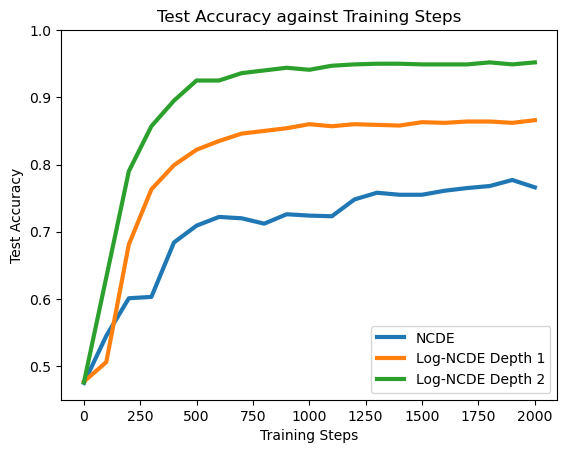

In [9]:
# Plot the results
for steps, test_accs, model_name in results:
    plt.plot(steps, test_accs, label=model_name, linewidth=3)
plt.ylim([0.45, 1])
plt.xlabel("Training Steps")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy against Training Steps")
plt.legend()
plt.show()